# Generative Model Example - PNC

Available weights for the BSNIP dataset and PNC dataset

BSNIP dataset:
- 1200+ subjects, single scan
- 20-60 yo
- Male, Female, CA, AA ethnicity
- normal controls, relatives, or schizophrenia, bipolar, and schizoaffective patients

PNC dataset:
- 1500+ subjects
- 4000+ scans
- 8 to 22 yo
- not selected for pathology
- Male, Female, EA, AA ethnicity

In [24]:
# Get frozen models

import requests as req
import os
from pathlib import Path

if not os.path.exists('../data'):
    os.makedirs('../data')
    
headers = {"User-Agent": "Mozilla/5.0 (Windows NT 10.0; Win64; x64)"}
    
for file in ['bsnip_gen_model.pkl', 'pnc_gen_model.pkl']:
    if not Path(f'../data/{file}').exists():
        r = req.get(f'http://hunimal.org/AngleBasis/{file}', headers=headers)
        with open(f'../data/{file}', 'wb') as f:
            f.write(r.content)
        print(f'Fetched {file}')
    else:
        print(f'{file} exists')
    
print('Complete')

Fetched bsnip_gen_model.pkl
Fetched pnc_gen_model.pkl
Complete


In [25]:
# Load fMRI-derived FC

import pickle

def vec2mat(vec, d, show_diag=True):
    a,b = np.triu_indices(d,1)
    x = np.eye(d) if show_diag else np.zeros((d,d))
    x[a,b] = vec
    x[b,a] = vec
    return x

def mat2vec(mat):
    a,b = np.triu_indices(mat.shape[0],1)
    return mat[a,b]

mpnc = pickle.load(open('../data/pnc_gen_model.pkl', 'rb'))

print('Done')

Done


In [43]:
# Synthetic subject parameters

# Age in years
# Logits in original models +-4 to 6 on training set

# 30 yo female CA ethnicity normal
sub1_pars = dict(age=18, sex=-20, race=-20)

# 30 yo male AA ethnicity sz diagnosis
sub2_pars = dict(age=10, sex=20, race=20)

print(sub1_pars, sub2_pars)

{'age': 18, 'sex': -20, 'race': -20} {'age': 10, 'sex': 20, 'race': 20}


In [44]:
import torch
import torch.nn as nn
import torch.nn.functional as F

nbasis = 5
mod = mpnc
nsubs = 10

def rmse(yt, yhat):
    return torch.mean((yt-yhat)**2)**0.5

class Gen(nn.Module):
    def __init__(self, mage, msex, mrace):
        super(Gen, self).__init__()
        self.wage = []
        self.bage = []
        self.wsex = []
        self.bsex = []
        self.wrace = []
        self.brace = []
        for mod in mage:
            self.wage.append(torch.from_numpy(mod.coef_.squeeze()).float().cuda())
            self.bage.append(torch.Tensor([mod.intercept_]).float().cuda())
        for mod in msex:
            self.wsex.append(torch.from_numpy(mod.coef_.squeeze()).float().cuda())
            self.bsex.append(torch.from_numpy(mod.intercept_).float().cuda())
        for mod in mrace:
            self.wrace.append(torch.from_numpy(mod.coef_.squeeze()).float().cuda())
            self.brace.append(torch.from_numpy(mod.intercept_).float().cuda())
        self.jitter = nn.Parameter((1/(nbasis*264)**0.5)*torch.randn(264,nbasis).float().cuda())
        self.thetas = nn.Parameter(torch.randn(nbasis,264).float().cuda())
        
        
    def fcimg(self):
        # Uncomment for AB with jitter
        t0 = self.thetas.unsqueeze(2)
        t1 = self.thetas.unsqueeze(1)
        m = torch.einsum('ab,cb->bac',self.jitter,self.jitter)
        return torch.mean(m*torch.cos(t0-t1), axis=0)
        # Uncomment for jitter-only
#         return self.jitter@self.jitter.T
    
    def fc(self):
        a,b = torch.triu_indices(264,264,offset=1)
        return self.fcimg()[a,b]
    
    def predict(self, age, sex, race):
        aerr = []
        serr = []
        rerr = []
        zerr = []
        efc = self.fc()
        for w,b in zip(self.wage, self.bage):
            aerr.append(rmse(age, w@efc+b))
        for w,b in zip(self.wsex, self.bsex):
            serr.append(torch.abs(sex-w@efc+b))
        for w,b in zip(self.wrace, self.brace):
            rerr.append(torch.abs(race-w@efc+b))
        return sum(aerr)/len(aerr), sum(serr)/len(serr), sum(rerr)/len(rerr)
    
nepochs = 50
pperiod = 100

subj1 = []
subj2 = []

for n in range(nsubs):
    gen = Gen(mod['age'], mod['sex'], mod['race'])
    optim = torch.optim.Adam(gen.parameters(), lr=1e-2, weight_decay=0)

    for epoch in range(nepochs):
        optim.zero_grad()

        fcloss = torch.sum(F.relu(torch.abs(gen.fc())-1))

        aloss, sloss, rloss = gen.predict(
            sub1_pars['age'], sub1_pars['sex'], sub1_pars['race'])
        (fcloss+aloss+sloss+rloss).backward()

        optim.step()
        if epoch % pperiod == 0 or epoch == nepochs-1:
            print(f'{epoch} {float(fcloss)} {float(aloss)} {float(sloss)} {float(rloss)}')
            
    subj1.append(gen.fcimg().detach().cpu().numpy())
    
for n in range(nsubs):
    gen = Gen(mod['age'], mod['sex'], mod['race'])
    optim = torch.optim.Adam(gen.parameters(), lr=1e-2, weight_decay=0)

    for epoch in range(nepochs):
        optim.zero_grad()

        fcloss = torch.sum(F.relu(torch.abs(gen.fc())-1))

        aloss, sloss, rloss = gen.predict(
            sub2_pars['age'], sub2_pars['sex'], sub2_pars['race'])
        (fcloss+aloss+sloss+rloss).backward()

        optim.step()
        if epoch % pperiod == 0 or epoch == nepochs-1:
            print(f'{epoch} {float(fcloss)} {float(aloss)} {float(sloss)} {float(rloss)}')
            
    subj2.append(gen.fcimg().detach().cpu().numpy())
    
print('Complete')

0 0.0 2.7290868759155273 21.86839485168457 14.237947463989258
49 0.0 0.5819565057754517 14.712855339050293 3.9398441314697266
0 0.0 2.729081869125366 21.8679256439209 14.237174034118652
49 0.0 0.47698840498924255 15.302810668945312 4.717764377593994
0 0.0 2.728955030441284 21.868289947509766 14.23825740814209
49 0.0 0.5097818374633789 15.331499099731445 4.562378406524658
0 0.0 2.7281980514526367 21.868249893188477 14.23832893371582
49 0.0 0.5222673416137695 14.680902481079102 3.956989288330078
0 0.0 2.7296130657196045 21.868284225463867 14.23827838897705
49 0.0 0.44731083512306213 14.396844863891602 3.8374974727630615
0 0.0 2.7291805744171143 21.86842155456543 14.238276481628418
49 0.0 0.4156179428100586 15.652310371398926 4.641298294067383
0 0.0 2.7285892963409424 21.86871910095215 14.23741340637207
49 0.0 0.3672367036342621 15.022384643554688 5.1290740966796875
0 0.0 2.7290728092193604 21.868606567382812 14.23778247833252
49 0.0 0.49148082733154297 15.207884788513184 4.61388969421386

In [39]:
# For plotting, so within-network ROIs are always together in FC maps

import numpy as np

ours2orig = [12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27,
28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 254, 41, 42, 43, 44, 45,
46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64,
65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 85,
86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103,
104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118,
119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 136, 138, 132,
133, 134, 135, 220, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152,
153, 154, 155, 156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167,
168, 169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 180, 185, 186,
187, 188, 189, 190, 191, 192, 193, 194, 195, 196, 197, 198, 199, 200, 201,
202, 203, 204, 205, 206, 207, 208, 209, 210, 211, 212, 213, 214, 215, 216,
217, 218, 219, 221, 222, 223, 224, 225, 226, 227, 228, 229, 230, 231, 232,
233, 137, 234, 235, 236, 237, 238, 239, 240, 241, 250, 251, 255, 256, 257,
258, 259, 260, 261, 262, 263, 242, 243, 244, 245, 0, 1, 2, 3, 4, 5, 6, 7, 8,
9, 10, 11, 83, 84, 131, 139, 140, 141, 181, 182, 183, 184, 246, 247, 248,
249, 252, 253]

def vec2mat(v):
    a,b = np.triu_indices(264,1)
    m = np.zeros((264,264))
    m[a,b] = v
    return m+m.T

def remap(fc, roimap=ours2orig):
    fc = fc[roimap,:]
    fc = fc[:,roimap]
    return fc

print('Complete')

Complete


/tmp/ipykernel_45767/2646023009.py:17: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


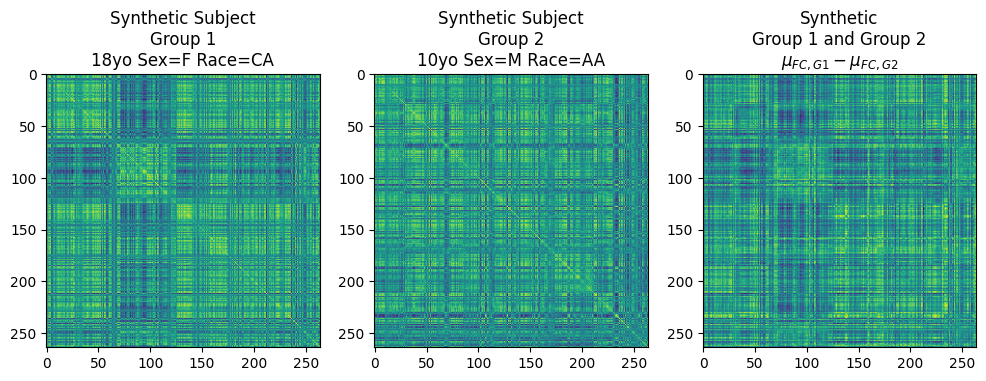

In [45]:
# Visualize representative subj1 and subj2, and average difference in synthetic groups
# See paper for true difference

import matplotlib.pyplot as plt

fig, ax = plt.subplots(1,3,figsize=(12,5))

ax[0].imshow(remap(subj1[0]))
ax[0].set_title('Synthetic Subject\nGroup 1\n18yo Sex=F Race=CA')

ax[1].imshow(remap(subj2[0]))
ax[1].set_title('Synthetic Subject\nGroup 2\n10yo Sex=M Race=AA')

ax[2].imshow(remap(np.mean(np.stack(subj1), axis=0)-np.mean(np.stack(subj2), axis=0)))
ax[2].set_title('Synthetic\nGroup 1 and Group 2\n$\mu_{FC,G1}-\mu_{FC,G2}$')

fig.show()

/tmp/ipykernel_45767/2282224892.py:10: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


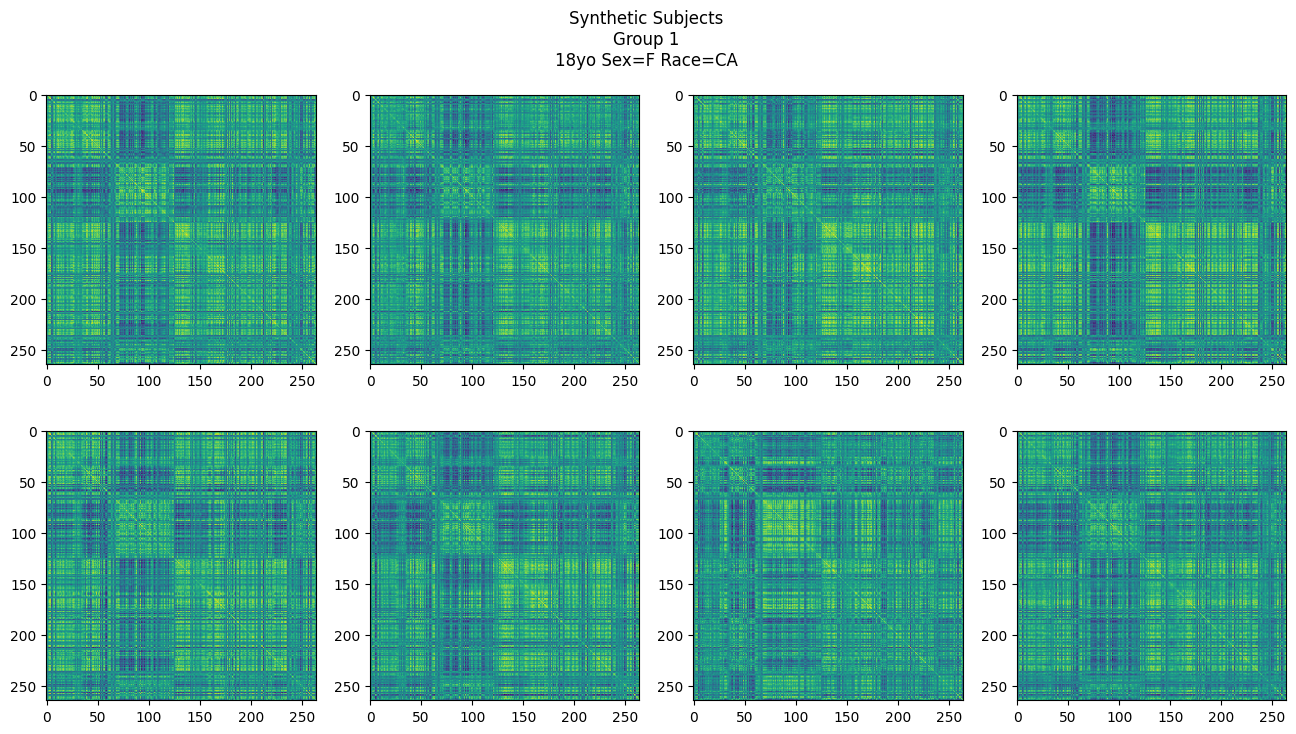

In [46]:
# Visualize distribution of synthetic subject 1

fig, ax = plt.subplots(2,4,figsize=(16,8))

for i in range(2):
    for j in range(4):
        ax[i][j].imshow(remap(subj1[i*4+j]))
        
fig.suptitle('Synthetic Subjects\nGroup 1\n18yo Sex=F Race=CA')
fig.show()

/tmp/ipykernel_45767/2773150395.py:10: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


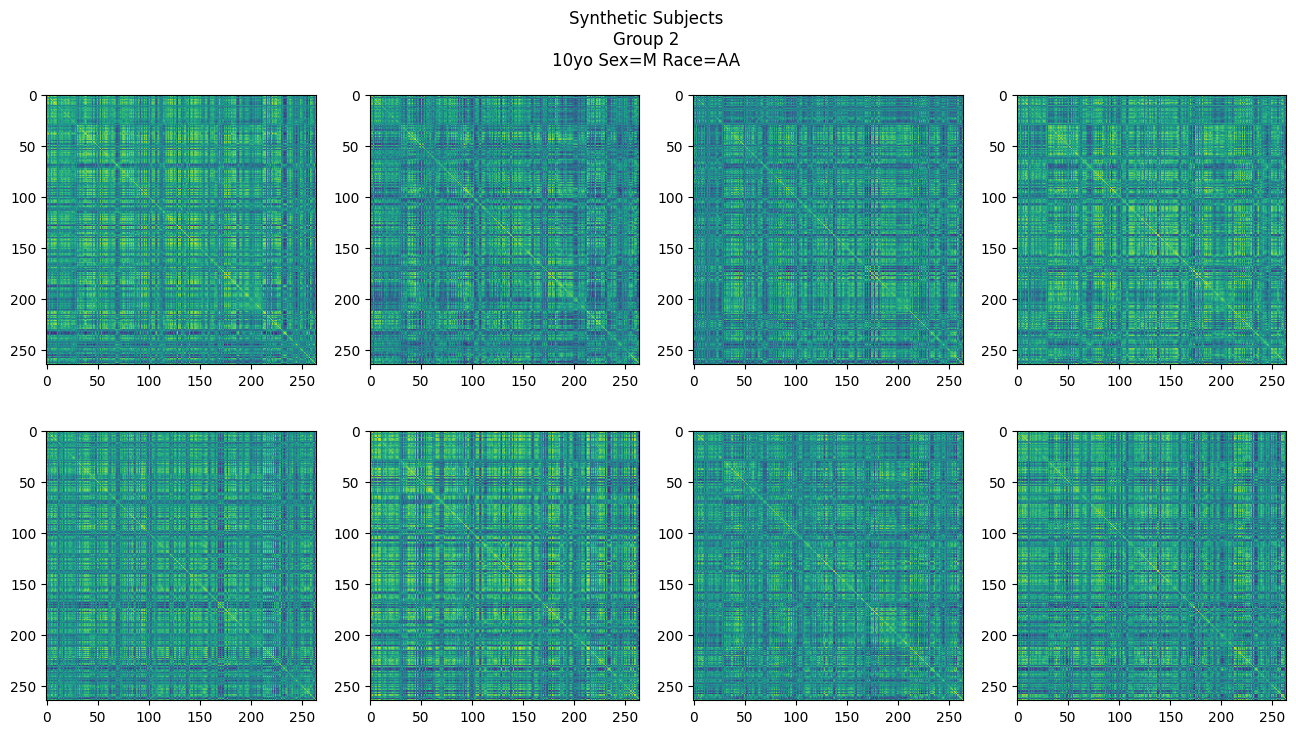

In [47]:
# Visualize distribution of synthetic subject 2

fig, ax = plt.subplots(2,4,figsize=(16,8))

for i in range(2):
    for j in range(4):
        ax[i][j].imshow(remap(subj2[i*4+j]))
        
fig.suptitle('Synthetic Subjects\nGroup 2\n10yo Sex=M Race=AA')
fig.show()